# **Análsiis de datos RNAseq: Análisis de Componentes Principales (PCA)**

El objetivo  de nuestro análisis es el siguiente: **analizar el perfil trancripcional de los macrófagos después de un oncoentrenamiento en el microambiente tumoral del cáncer de mama.**

Para ello, hemos estado trabajando con datos RNAseq bulk de tipo pareados. Por cuestiones administrativas tenemos datos de dos lotes de secuenciación independientes. El [primer lote](https://www.dropbox.com/scl/fi/2cqhplg823qp7acbqei64/macs_lote1_fasqtc.html?rlkey=nabuzu7m327ofocs158qbdo0h&st=gix7xet6&dl=0) (Lote 1, *TruSeq RNA sample prep v2 LT*) tiene una calidad adecuada, todas nuestras lecturas (100pb) mostraban una puntuación Phred score mayor a 34 y con un promedio de 28.7 millones de lecturas por biblioteca. Sin embargo, nuestra preocupación viene del [segundo lote](https://www.dropbox.com/scl/fi/fojsefux3vpk486g4e6hv/macs_lote2_fastqc.html?rlkey=6a3rww1596vp0xo9tfcm5bmua&st=j06zj0k7&dl=0) (lote 2 *NovaSeq de Illumina*), cuyas lecturas (150pb) no tienen la misma calidad, en especial las R2. La puntuación Phred para estas lecturas cae hasta 20. En tanto, el R1, cae hasta 22 en la escala Phred. El promedio de lecturas por biblioteca es de 22.7 millones.

Ante el escenario mencionado decidimos hacer [*trimming*](https://www.dropbox.com/scl/fi/ikf7plh4qdrgupxaqn6oc/trimming_macs_lote2_fastqc.html?rlkey=i7vajjwnwnez02k2yrfmpxoi6&st=2dkp0ozj&dl=0) sobre el lote 2, las recortamos a 100 pb, así elevamos la puntuación Phred 27 y 21, para la lectura R1&R2, respectivamente, conservando las 22.7 millones de read en promedio por biblioteca.

Nuestro siguiente paso fue alinear las secuencias de forma independiente con STAR. Para el [lote 1](https://www.dropbox.com/scl/fi/6ed2rs67cvm3ujmv19jer/alignment_macs_lote1.html?rlkey=i9euxzuvnknmu1b371pz6eepx&st=qr15rane&dl=0) obtuvimos un porcentaje de alineamiento único del 92% en promedio para todas las muestras, lo cual nos generó mucha alegría. En tanto el [lote 2](https://www.dropbox.com/scl/fi/vhu9x2bslnou7qmjgqver/alignment_trimming_macs_lote2.html?rlkey=miuu614gv2nyx97g5uju931im&st=zaq83n2a&dl=0), obtuvimos un porcentaje de alineamineto único del 83%, lo cual nos tiene un poco consternados. **Consideramos que la calidad de secuenciación del lote 2 es menor a la obtenida en el lote 1.** 

Posterior al alineamiento, ensamblamos y cuantificamos con Stringtie. Aquí te mostramos el flujo de trabajo:

![Esquema de nuestro flujo de trabajo](work_flow_transcriptome.png "Flujo de trabajo")

**El asunto en todo es: ¿los datos provenientes del lote 2 son confiables? ¿el segundo lote  de secuenciacióne es viable? ¿puedo homogenizar ambos lotes de secuenciación?**

Lo que pretendemos con los siguientes análisis es homogenizar los datos de secuenación RNAseq, provenientes de dos eventos distintos de secuenciación, para poder hacer comparativas adecuadas. Para ello haremos un PCA para observar el comportamiento, agrupación de los datos y encontrar posibles efectos por lote u otros artefactos. En caso de existir dicho efecto debemos solucionarlo y verificar su resolución mediante otro PCA, en el cual la distribución de los datos debería ser homogena. **La intención de este análisis es poder homegenizar ambos lotes de secuenciacíon**, considerando que la calidad del lote 1 es mayor a la del lote 2, respecto a las lecturas obtenidas.

Lo primero que necesitamos es instalar las librerías necesarias para realizar el PCA:

In [1]:
# Instalar librerías
#!pip install pandas numpy scikit-learn matplotlib seaborn kneed

In [2]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

Ahora seguimos propiamente con el **Análisis de Componentes Principales**. En primer lugar, analizamos los datos del lote 1. Estos datos se ensamblaron y cuantificaron de forma independiente al lote 2. Es importante considerar que parte de los argumentos para contruir el PCA, es centrar y escalar los datos, lo cual afecta la forma en que se comporta la varianza.

Primero vamos a definir un par de funciones para realizar el PCA:
+ centrando y escalando los datos; analyze_pca_center_scale.
+ sin centrar ni escalar los datos; analyze_pca_analyze_pca_no_center_scale.
+ PCA & Batch centrando y escalando los datos; analyze_pca_center_scale_batch.
+ PCA & Batch sin centrar ni escalar los datos; analyze_pca_analyze_pca_no_center_scale_batch.
+ PCA,Batch, Cluster sin centrar ni escalar los datos; analyze_pca_and_cluster

Cada análisis arrojará: la varianza explicada por cada componente; la acumulación de la varianza a través de los componetes junto con un Scree Plot; la matriz de carga y la visualización gráfica del Análisis de Componentes Principales.

In [3]:
# PCA: Datos centrados y escalados: (analyze_pca_center_scale)
def analyze_pca_center_scale(file_path):
    """
    Realiza análisis de PCA sobre un archivo dado y muestra los resultados gráficos.
    
    Args:
        file_path (): Ruta al archivo CSV a analizar.
    """
    # Cargar los datos
    data = pd.read_csv(file_path, index_col=0)
        
    # Filtrar datos y prepararlos
    data = data.loc[data.sum(axis=1) != 0]  # Eliminar filas cuya suma sea 0
    df_tras = data.T  # Transponer el dataframe
    
    # Centrar y escalar los datos
    scaler = StandardScaler()
    df_tras_scaled = scaler.fit_transform(df_tras)
    
    # Realizar PCA
    pca = PCA()
    pca_result = pca.fit_transform(df_tras_scaled)
    
    # Crear un dataframe con las dos primeras componentes principales
    pca_data = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=df_tras.index)
    
    # Calcular varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Mostrar resultados básicos
    print(f"Varianza explicada por cada componente: {explained_variance}")
    print()
    print(f"Varianza acumulada: {cumulative_variance}")
    
    # Visualización de la varianza explicada (Scree Plot)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title('Scree Plot')
    plt.axhline(60, color='r', linestyle='--', label='60% Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Matriz de cargas (loadings)
    loadings = pd.DataFrame(
        pca.components_,
        columns=df_tras.columns,
        index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
    )
    print("Matriz de Cargas para todas las Componentes Principales:")
    print(loadings)
    
    # Función para asignar etiquetas
    def assign_label(cond_name):
        if cond_name.startswith("basal_"):
            return "Monocyte"
        elif cond_name.startswith("gmcsf_"):
            return "Macrophage GM-CSF"
        elif cond_name.startswith("uivc_hs"):
            return "HS578T"
        elif cond_name.startswith("mcf7_"):
            return "MCF7"
        elif cond_name.startswith("mda231_"):
            return "MDA-MB-231"
        elif cond_name.startswith("uivc_p16_"):
            return "MBCDF-16"
        elif cond_name.startswith("t47d_"):
            return "T47D"
        elif cond_name.startswith("uivc_160_"):
            return "UIVC-IDC-2"
        elif cond_name.startswith("uivc_169_"):
            return "UIVC-IDC-3"
        elif cond_name.startswith("uivc_172_"):
            return "UIVC-IDC-1b"
        elif cond_name.startswith("uivc_183_"):
            return "UIVC-IDC-9"
        elif cond_name.startswith("uivc1_"):
            return "UIVC-IDC-1"
        elif cond_name.startswith("uivc4_"):
            return "UIVC-IDC-4"
        else:
            return "Other"
    
    # Asignar etiquetas a las muestras
    pca_data['Condicion'] = pca_data.index.map(assign_label)
    
    # Graficar los resultados del PCA
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Condicion', palette='Set2', s=100)
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title("PCA of Gene Expression Data (Centered and Scaled)")
    plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [4]:
# PCA: Datos no centrados ni escalados: (analyze_pca_no_center_scale)
def analyze_pca_no_center_scale(file_path):
    """
    Realiza un análisis de PCA sin centrar ni escalar los datos y muestra los resultados gráficos.

    Args:
        file_path (str): Ruta al archivo CSV a analizar. Debe tener genes como índices y condiciones experimentales como columnas.
    """
    # Cargar los datos
    data = pd.read_csv(file_path, index_col=0)
    
    # Filtrar datos y prepararlos
    data = data.loc[data.sum(axis=1) != 0]  # Eliminar filas cuya suma sea 0
    df_tras = data.T  # Transponer el dataframe
    
    # Realizar PCA (sin centrar ni escalar los datos)
    pca = PCA()
    pca_result = pca.fit_transform(df_tras)
    
    # Crear un dataframe con las dos primeras componentes principales
    pca_data = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=df_tras.index)
    
    # Calcular varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Mostrar resultados básicos
    print(f"Varianza explicada por cada componente: {explained_variance}")
    print()
    print(f"Varianza acumulada: {cumulative_variance}")
    
    # Visualizar la varianza explicada (Scree Plot)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title('Scree Plot')
    plt.axhline(60, color='r', linestyle='--', label='60% Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

    # Matriz de cargas (loadings)
    loadings = pd.DataFrame(
        pca.components_,
        columns=df_tras.columns,
        index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
    )
    print("Matriz de Cargas para todas las Componentes Principales:")
    print(loadings)
    
    # Función para asignar etiquetas
    def assign_label(cond_name):
        if cond_name.startswith("basal_"):
            return "Monocyte"
        elif cond_name.startswith("gmcsf_"):
            return "Macrophage GM-CSF"
        elif cond_name.startswith("uivc_hs"):
            return "HS578T"
        elif cond_name.startswith("mcf7_"):
            return "MCF7"
        elif cond_name.startswith("mda231_"):
            return "MDA-MB-231"
        elif cond_name.startswith("uivc_p16_"):
            return "MBCDF-16"
        elif cond_name.startswith("t47d_"):
            return "T47D"
        elif cond_name.startswith("uivc_160_"):
            return "UIVC-IDC-2"
        elif cond_name.startswith("uivc_169_"):
            return "UIVC-IDC-3"
        elif cond_name.startswith("uivc_172_"):
            return "UIVC-IDC-1b"
        elif cond_name.startswith("uivc_183_"):
            return "UIVC-IDC-9"
        elif cond_name.startswith("uivc1_"):
            return "UIVC-IDC-1"
        elif cond_name.startswith("uivc4_"):
            return "UIVC-IDC-4"
        else:
            return "Other"
    
    # Asignar etiquetas a las muestras
    pca_data['Condicion'] = pca_data.index.map(assign_label)
    
    # Graficar los resultados del PCA
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Condicion', palette='Set2', s=150)
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title("PCA of Gene Expression Data (No Center & No Scale)")
    plt.legend(title="Cell type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [5]:
# PCA & BATCH: Datos centrados y escalados: (analyze_pca_center_scale_batch)
def analyze_pca_center_scale_batch(file_path):
    """
    Realiza análisis de PCA sobre un archivo dado y muestra los resultados gráficos.
    
    Args:
        file_path (): Ruta al archivo CSV a analizar.
    """
    # Cargar los datos
    data = pd.read_csv(file_path, index_col=0)
        
    # Filtrar datos y prepararlos
    data = data.loc[data.sum(axis=1) != 0]  # Eliminar filas cuya suma sea 0
    df_tras = data.T  # Transponer el dataframe
    
    # Centrar y escalar los datos
    scaler = StandardScaler()
    df_tras_scaled = scaler.fit_transform(df_tras)
    
    # Realizar PCA
    pca = PCA()
    pca_result = pca.fit_transform(df_tras_scaled)
    
    # Crear un dataframe con las dos primeras componentes principales
    pca_data = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=df_tras.index)
    
    # Calcular varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Mostrar resultados básicos
    print(f"Varianza explicada por cada componente: {explained_variance}")
    print()
    print(f"Varianza acumulada: {cumulative_variance}")
    
    # Visualización de la varianza explicada (Scree Plot)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title('Scree Plot')
    plt.axhline(60, color='r', linestyle='--', label='60% Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()
    
    # Matriz de cargas (loadings)
    loadings = pd.DataFrame(
        pca.components_,
        columns=df_tras.columns,
        index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
    )
    print("Matriz de Cargas para todas las Componentes Principales:")
    print(loadings)
    
    # Función para asignar etiquetas
    def assign_label(cond_name):
        if cond_name.startswith("basal_"):
            return "Monocyte"
        elif cond_name.startswith("gmcsf_"):
            return "Macrophage GM-CSF"
        elif cond_name.startswith("uivc_hs"):
            return "HS578T"
        elif cond_name.startswith("mcf7_"):
            return "MCF7"
        elif cond_name.startswith("mda231_"):
            return "MDA-MB-231"
        elif cond_name.startswith("uivc_p16_"):
            return "MBCDF-16"
        elif cond_name.startswith("t47d_"):
            return "T47D"
        elif cond_name.startswith("uivc_160_"):
            return "UIVC-IDC-2"
        elif cond_name.startswith("uivc_169_"):
            return "UIVC-IDC-3"
        elif cond_name.startswith("uivc_172_"):
            return "UIVC-IDC-1b"
        elif cond_name.startswith("uivc_183_"):
            return "UIVC-IDC-9"
        elif cond_name.startswith("uivc1_"):
            return "UIVC-IDC-1a"
        elif cond_name.startswith("uivc4_"):
            return "UIVC-IDC-4"
        else:
            return "Other"

    # Función para asignar el lote
    def assign_batch(cond_name):
        lote1 = ["Monocyte", "Macrophage GM-CSF", "MCF7", "MDA-MB-231", "T47D", "UIVC-IDC-1a", "UIVC-IDC-4"]
        if assign_label(cond_name) in lote1:
            return "Batch 1"
        else:
            return "Batch 2"

    # Asignar etiquetas a las muestras
    pca_data['Condicion'] = pca_data.index.map(assign_label)
    pca_data['Batch'] = pca_data.index.map(assign_batch)

    # Definir la paleta de colores personalizada (un diccionario clave: color)
    custom_palette = {
        "Monocyte": "darkblue",
        "Macrophage GM-CSF": "red",
        "HS578T": "darkgreen",
        "MCF7": "purple",
        "MDA-MB-231": "tomato",
        "MBCDF-16": "darkorange",
        "T47D": "magenta",
        "UIVC-IDC-2": "palegreen",
        "UIVC-IDC-3": "turquoise",
        "UIVC-IDC-1b": "deeppink",
        "UIVC-IDC-9": "dodgerblue",
        "UIVC-IDC-1a": "violet",  
        "UIVC-IDC-4": "firebrick",
        "Other": "black"
    }

    # Graficar el PCA con colores para las condiciones y formas para los lotes
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Condicion', style='Batch', palette=custom_palette, s=100)
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title("PCA of Gene Expression Data (Centered and Scaled)")
    plt.legend(title="Cell type & Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [6]:
# PCA & BATCH: Datos no centrados ni escalados: (analyze_pca_no_center_scale_batch)
def analyze_pca_no_center_scale_batch(file_path):
    """
    Realiza un análisis de PCA sin centrar ni escalar los datos y muestra los resultados gráficos.

    Args:
        file_path (str): Ruta al archivo CSV a analizar. Debe tener genes como índices y condiciones experimentales como columnas.
    """
    # Cargar los datos
    data = pd.read_csv(file_path, index_col=0)
    
    # Filtrar datos y prepararlos
    data = data.loc[data.sum(axis=1) != 0]  # Eliminar filas cuya suma sea 0
    df_tras = data.T  # Transponer el dataframe
    
    # Realizar PCA (sin centrar ni escalar los datos)
    pca = PCA()
    pca_result = pca.fit_transform(df_tras)
    
    # Crear un dataframe con las dos primeras componentes principales
    pca_data = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=df_tras.index)
    
    # Calcular varianza explicada y acumulada
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Mostrar resultados básicos
    print(f"Varianza explicada por cada componente: {explained_variance}")
    print()
    print(f"Varianza acumulada: {cumulative_variance}")
    
    # Visualizar la varianza explicada (Scree Plot)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title('Scree Plot')
    plt.axhline(60, color='r', linestyle='--', label='60% Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

    # Matriz de cargas (loadings)
    loadings = pd.DataFrame(
        pca.components_,
        columns=df_tras.columns,
        index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
    )
    print("Matriz de Cargas para todas las Componentes Principales:")
    print(loadings)

    # Función para asignar etiquetas
    def assign_label(cond_name):
        if cond_name.startswith("basal_"):
            return "Monocyte"
        elif cond_name.startswith("gmcsf_"):
            return "Macrophage GM-CSF"
        elif cond_name.startswith("uivc_hs"):
            return "HS578T"
        elif cond_name.startswith("mcf7_"):
            return "MCF7"
        elif cond_name.startswith("mda231_"):
            return "MDA-MB-231"
        elif cond_name.startswith("uivc_p16_"):
            return "MBCDF-16"
        elif cond_name.startswith("t47d_"):
            return "T47D"
        elif cond_name.startswith("uivc_160_"):
            return "UIVC-IDC-2"
        elif cond_name.startswith("uivc_169_"):
            return "UIVC-IDC-3"
        elif cond_name.startswith("uivc_172_"):
            return "UIVC-IDC-1b"
        elif cond_name.startswith("uivc_183_"):
            return "UIVC-IDC-9"
        elif cond_name.startswith("uivc1_"):
            return "UIVC-IDC-1a"
        elif cond_name.startswith("uivc4_"):
            return "UIVC-IDC-4"
        else:
            return "Other"

    # Función para asignar el lote
    def assign_batch(cond_name):
        lote1 = ["Monocyte", "Macrophage GM-CSF", "MCF7", "MDA-MB-231", "T47D", "UIVC-IDC-1a", "UIVC-IDC-4"]
        if assign_label(cond_name) in lote1:
            return "Batch 1"
        else:
            return "Batch 2"

    # Asignar etiquetas a las muestras
    pca_data['Condicion'] = pca_data.index.map(assign_label)
    pca_data['Batch'] = pca_data.index.map(assign_batch)

    # Definir la paleta de colores personalizada (un diccionario clave: color)
    custom_palette = {
        "Monocyte": "darkblue",
        "Macrophage GM-CSF": "red",
        "HS578T": "darkgreen",
        "MCF7": "purple",
        "MDA-MB-231": "tomato",
        "MBCDF-16": "darkorange",
        "T47D": "magenta",
        "UIVC-IDC-2": "palegreen",
        "UIVC-IDC-3": "turquoise",
        "UIVC-IDC-1b": "deeppink",
        "UIVC-IDC-9": "dodgerblue",
        "UIVC-IDC-1a": "violet",  
        "UIVC-IDC-4": "firebrick",
        "Other": "black"
    }

    # Graficar el PCA con colores para las condiciones y formas para los lotes
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Condicion', style='Batch', palette=custom_palette, s=100)
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title("PCA of Gene Expression Data (No Center & No Scale)")
    plt.legend(title="Cell type & Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

#### **PCA: Lote 1 con datos escalados y centrados:**

Varianza explicada por cada componente: [3.84714586e+01 1.07787921e+01 6.95838285e+00 5.76190297e+00
 3.23606902e+00 1.60228817e+00 1.48806519e+00 1.39796043e+00
 1.24297393e+00 1.14253880e+00 1.11781334e+00 1.09019306e+00
 1.06672321e+00 1.02330865e+00 1.01935078e+00 9.99433060e-01
 9.94797049e-01 9.83417526e-01 9.70897072e-01 9.56711084e-01
 9.47585952e-01 9.43048095e-01 9.41426260e-01 9.23389486e-01
 9.20417261e-01 8.93779525e-01 8.81716694e-01 8.80209333e-01
 8.75573896e-01 8.68257150e-01 8.57001652e-01 8.43622573e-01
 8.37814885e-01 8.15899952e-01 7.96127253e-01 7.79899034e-01
 7.59185180e-01 7.52277212e-01 7.41324524e-01 7.28832169e-01
 7.09535117e-01 7.58606552e-30]

Varianza acumulada: [ 38.47145857  49.25025063  56.20863347  61.97053644  65.20660546
  66.80889363  68.29695882  69.69491925  70.93789318  72.08043198
  73.19824532  74.28843837  75.35516158  76.37847023  77.39782101
  78.39725407  79.39205112  80.37546864  81.34636572  82.3030768
  83.25066275  84.19371085  85.135

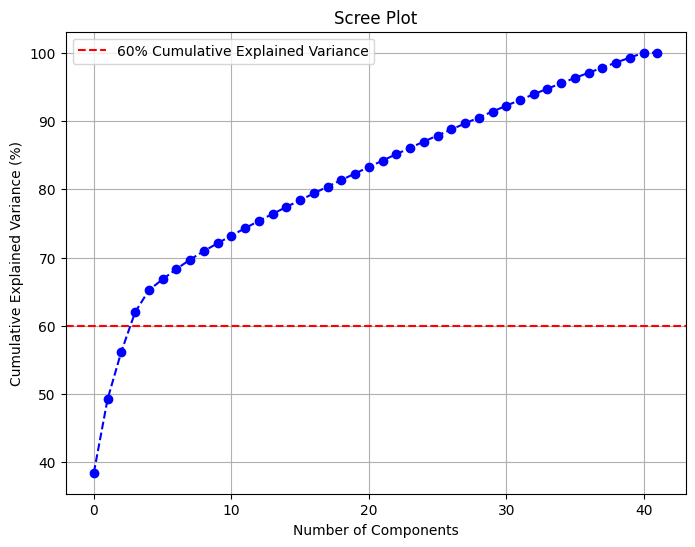

Matriz de Cargas para todas las Componentes Principales:
gene_name  5_8S_rRNA      A1BG      AAAS      AACS     AAGAB      AAK1  \
PC1        -0.004071  0.001693 -0.002757 -0.013286 -0.006624  0.002259   
PC2        -0.008541  0.010223 -0.008583 -0.017189 -0.026389 -0.006055   
PC3        -0.022087 -0.013196 -0.007677  0.017560  0.017033  0.003663   
PC4        -0.016111 -0.020753  0.006677 -0.004214  0.006671 -0.002500   
PC5         0.039430  0.022760 -0.015622  0.001141  0.004821 -0.011162   
PC6        -0.000809  0.024332 -0.029937  0.005603 -0.007923  0.005431   
PC7        -0.007852 -0.002902  0.016529 -0.014094 -0.005263  0.000097   
PC8         0.010600  0.009795  0.002373  0.009669 -0.006804  0.016351   
PC9        -0.005891  0.027280  0.008394 -0.011678  0.007743 -0.003121   
PC10        0.011481  0.000819 -0.018605  0.005143  0.007536  0.013794   
PC11       -0.000438 -0.002312  0.015440  0.002911  0.010901  0.004239   
PC12        0.015788  0.004821  0.020683  0.004423 -0.0

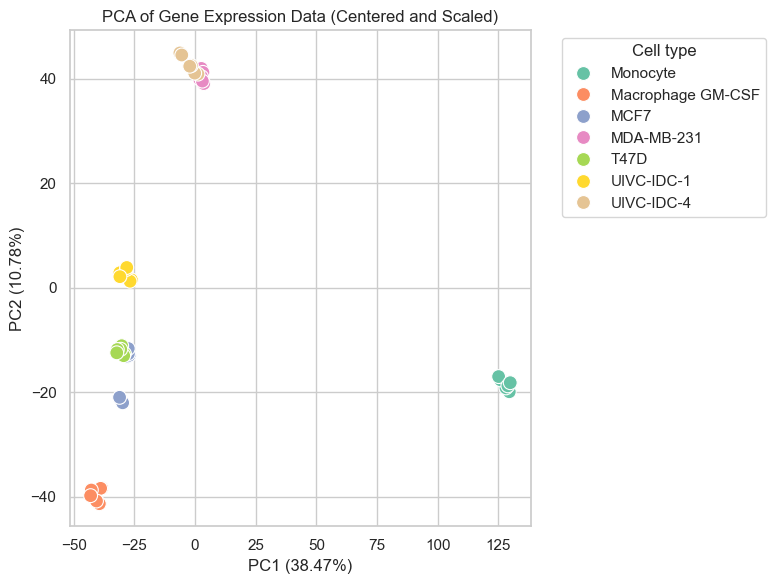

In [7]:
# PCA centrado y escalado:
analyze_pca_center_scale("fpkm_all_samples_with_genes_wiso_mean_L1.csv")

El porcentaje de varianza explicado es muy bajo, aunque la distribución de las muestras es correcta. Sin embargo, no es necesario centrar ni escalar los datos, porque todas las muestras fueron ensambladas y cuantificadas en el mismo evento, es decir, se normalizaron juntas, de tal forma que tiene la misma unidad de medición y magnitud. Entonces el PCA sin estos parámetros es el siguiente:

#### **PCA: Lote 1 sin escalar ni centrar los datos:**

Varianza explicada por cada componente: [8.49325608e+01 7.71254109e+00 4.67561614e+00 1.13240402e+00
 6.93911089e-01 3.22515823e-01 1.31070830e-01 8.87870382e-02
 4.65953528e-02 3.74628866e-02 2.91570763e-02 2.23594785e-02
 1.77314739e-02 1.60186468e-02 1.14847629e-02 1.04007271e-02
 9.67541307e-03 9.00310302e-03 8.59023601e-03 7.69738604e-03
 6.53079731e-03 6.00237770e-03 5.78477514e-03 5.25926274e-03
 5.10141390e-03 5.01044249e-03 4.46087193e-03 4.32948818e-03
 4.31674999e-03 4.09203654e-03 3.87455699e-03 3.67589216e-03
 3.37144053e-03 3.27041197e-03 3.21015611e-03 3.04707026e-03
 2.94575146e-03 2.79139118e-03 2.56296675e-03 2.43069513e-03
 2.34803491e-03 1.67499942e-29]

Varianza acumulada: [ 84.93256084  92.64510193  97.32071807  98.45312209  99.14703318
  99.46954901  99.60061984  99.68940687  99.73600223  99.77346511
  99.80262219  99.82498167  99.84271314  99.85873179  99.87021655
  99.88061728  99.89029269  99.89929579  99.90788603  99.91558342
  99.92211421  99.92811659  99.93

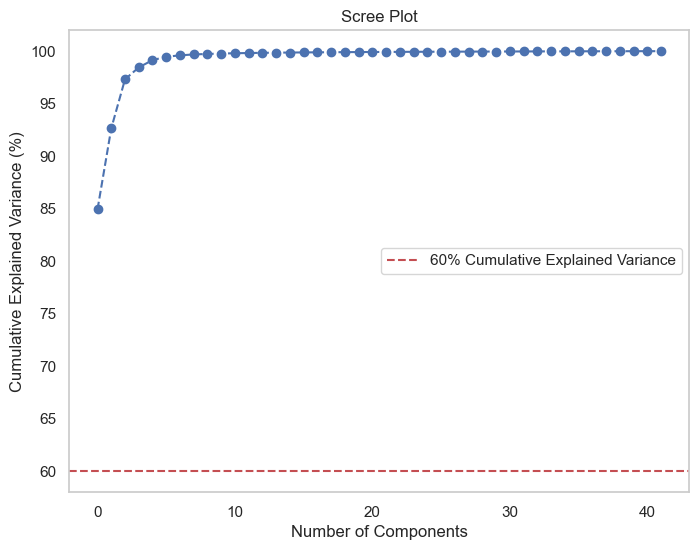

Matriz de Cargas para todas las Componentes Principales:
gene_name  5_8S_rRNA      A1BG          AAAS      AACS     AAGAB      AAK1  \
PC1         0.000025  0.000028  8.471639e-06  0.000067 -0.000029 -0.000046   
PC2        -0.000682  0.000105 -3.725678e-04 -0.000419 -0.000209 -0.000010   
PC3         0.000139  0.000340  1.086510e-07 -0.001064 -0.000366 -0.000044   
PC4        -0.000033  0.000566  5.589222e-05  0.000271 -0.000039  0.000273   
PC5         0.000280  0.000305 -1.411131e-04 -0.000209 -0.000008 -0.000211   
PC6         0.004362  0.001739 -1.660985e-03  0.000109 -0.000127 -0.000689   
PC7         0.000173  0.001340 -1.868555e-03  0.000434 -0.000202  0.001111   
PC8         0.003465  0.001081  2.533979e-03 -0.002021 -0.000739 -0.000550   
PC9        -0.002937  0.000618  3.383266e-04 -0.001859  0.000456 -0.002497   
PC10       -0.005245 -0.002174 -1.304162e-03 -0.001118  0.000061  0.000842   
PC11       -0.002364 -0.002912  7.055111e-04  0.000021  0.000416  0.000006   
PC12   

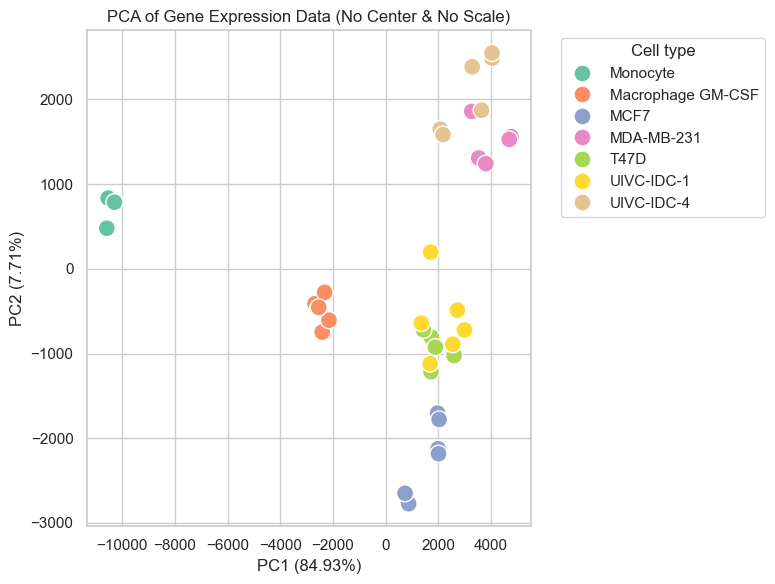

In [8]:
# PCA sin centrar ni escalar:
analyze_pca_no_center_scale("fpkm_all_samples_with_genes_wiso_mean_L1.csv")

Como podemos observar la varianza explicada por el PC1 es alta, más del 80%. Si bien observamos la distribución esperada de las muestras, creo que este porcentaje es muy alto, incluso considerando que estamos trabajando con los monocitos lo cuál es una variable biológica importante a considerar **¿Cómo se ve el análisis si excluimos a los monocitos?**

#### **PCA: Lote 1 sin escalar ni centrar los datos exluyendo a los monocitos:**

Varianza explicada por cada componente: [6.63367595e+01 2.37164847e+01 4.34293274e+00 2.41104603e+00
 1.45423138e+00 5.38381570e-01 3.04074720e-01 1.70411519e-01
 1.17520906e-01 7.81810554e-02 6.00869833e-02 5.17815766e-02
 4.00216208e-02 3.42134664e-02 3.13522280e-02 3.06934141e-02
 2.53983587e-02 2.23253856e-02 2.15192140e-02 2.07849530e-02
 1.82628308e-02 1.72016967e-02 1.66508382e-02 1.53945672e-02
 1.47972278e-02 1.39728057e-02 1.30096046e-02 1.27767624e-02
 1.12972921e-02 1.08671070e-02 1.06645379e-02 1.03638496e-02
 9.23335130e-03 8.85433512e-03 8.45185760e-03 2.05159512e-29]

Varianza acumulada: [ 66.33675952  90.05324421  94.39617695  96.80722298  98.26145436
  98.79983593  99.10391065  99.27432217  99.39184308  99.47002414
  99.53011112  99.5818927   99.62191432  99.65612778  99.68748001
  99.71817342  99.74357178  99.76589717  99.78741638  99.80820134
  99.82646417  99.84366586  99.8603167   99.87571127  99.8905085
  99.9044813   99.91749091  99.93026767  99.94156496  99.952

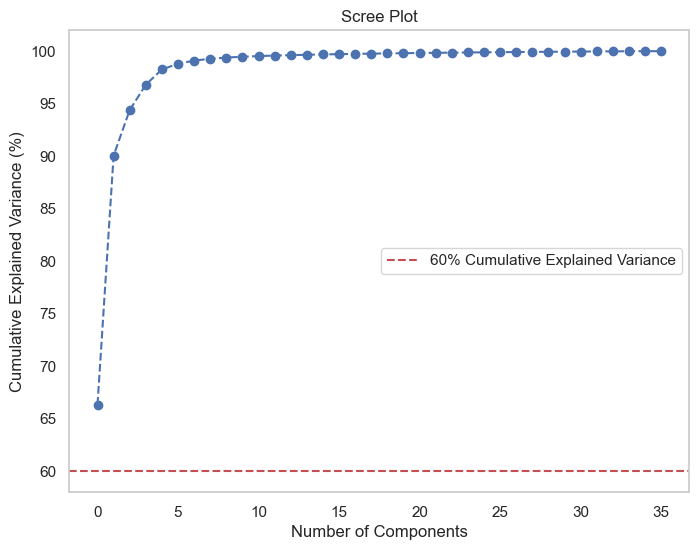

Matriz de Cargas para todas las Componentes Principales:
gene_name  5_8S_rRNA      A1BG      AAAS      AACS         AAGAB      AAK1  \
PC1        -0.000212  0.000147 -0.000105 -0.000464 -2.239792e-04 -0.000049   
PC2         0.000635  0.000053  0.000326 -0.000129  3.889260e-06 -0.000013   
PC3         0.000141  0.000721 -0.000046 -0.000165 -1.682467e-04  0.000167   
PC4         0.000179  0.000269 -0.000132 -0.000109  5.018877e-06 -0.000167   
PC5         0.003524  0.001384 -0.001330 -0.000620 -2.409432e-04 -0.000912   
PC6         0.001860  0.001573 -0.001797  0.001084  7.609143e-07  0.001198   
PC7         0.003568  0.001213  0.002624 -0.001978 -7.003619e-04 -0.000305   
PC8        -0.004478  0.000211 -0.000632 -0.002105  3.182149e-04 -0.001415   
PC9        -0.002065 -0.000309 -0.001439 -0.000362 -2.259971e-04  0.002338   
PC10       -0.007669 -0.005497 -0.000083 -0.000702  5.536236e-05 -0.002925   
PC11        0.001924  0.001774 -0.002130 -0.000035 -1.616947e-03 -0.002023   
PC12   

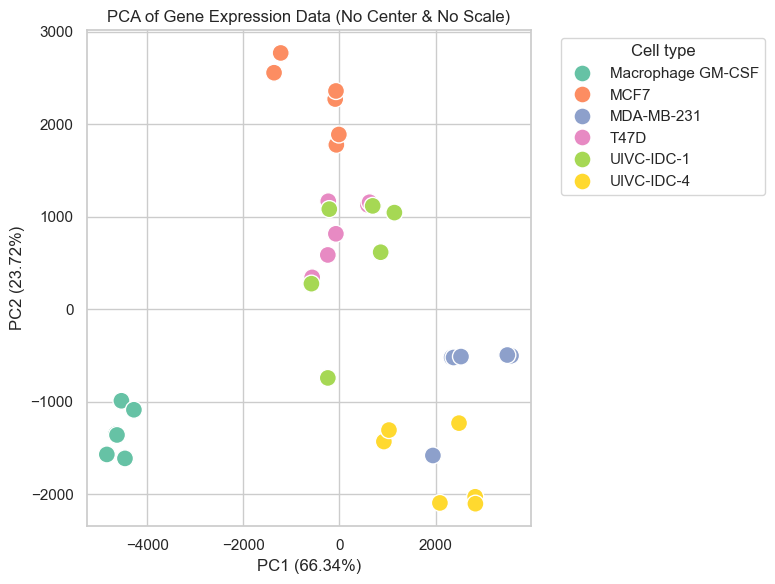

In [9]:
# PCA # PCA sin centrar ni escalar excluyendo los monocitos:
analyze_pca_no_center_scale("fpkm_macs_with_genes_wiso_mean_L1.csv")

Si solo contemplamos los macrófagos el procentaje explicado por el PC1 ahora es menor que con los monocitos ¿los monocitos están teniendo mucho peso en la varianza de los datos? Me precupa que hay un comportamieno inusual de algunas muestras (UIVC-IDC-1 & MDA-MB-231), el cuál no había visto en análisis previos... bueno, llama mi antención. 

**En teoría estos datos me dan confizan porque el lote 1 tiene una gran calidad de secueciación y alineamiento. Pero los porcentajes tan altos del PCA con monocitos y la dispersión de algunas muestras de macrófagos en el PCA sin monocitos me hacen mucho ruído... ¿Qué está pasando?**

Ahora vamos integrar el lote 2 a nuestro análisis. En este punto tomé ambos lotes de secuecuaciación, los ensamble y cuantifiqué juntos, para que la normalización fuera homogénea. 

#### **PCA: Lote 1 & 2 con datos centrados y escalados:**

Varianza explicada por cada componente: [2.31931162e+01 1.37208804e+01 6.03185878e+00 5.33618325e+00
 3.83567225e+00 3.25146315e+00 2.72481002e+00 2.49060621e+00
 2.01761245e+00 1.70443627e+00 1.66323691e+00 1.19298642e+00
 1.17593682e+00 1.07282912e+00 9.64734710e-01 8.78978974e-01
 8.57048820e-01 7.73072942e-01 7.49993928e-01 7.35421271e-01
 6.94091915e-01 6.87700293e-01 6.76387808e-01 6.65909524e-01
 6.55632558e-01 6.44687508e-01 6.37863531e-01 6.25280989e-01
 6.14578897e-01 6.05092640e-01 6.02048016e-01 5.96406286e-01
 5.87093876e-01 5.73283256e-01 5.70292028e-01 5.64091500e-01
 5.61703743e-01 5.55095704e-01 5.39295282e-01 5.31710678e-01
 5.30318721e-01 5.09734748e-01 4.94200396e-01 4.91493641e-01
 4.69845496e-01 4.67248076e-01 4.51329075e-01 4.48060992e-01
 4.41585651e-01 4.27575519e-01 4.17064110e-01 4.10406205e-01
 4.06708167e-01 4.03340462e-01 3.99698412e-01 3.97948399e-01
 3.94501753e-01 3.91277368e-01 3.78952198e-01 3.78295048e-01
 3.71790277e-01 3.67291187e-01 3.62637050e-01

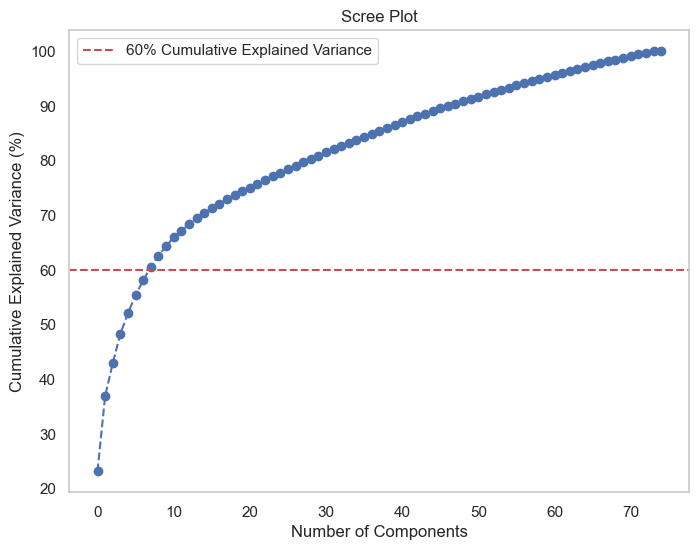

Matriz de Cargas para todas las Componentes Principales:
gene_name  5_8S_rRNA      A1BG      AAAS      AACS     AAGAB      AAK1  \
PC1         0.002502 -0.008640 -0.002151  0.012721  0.012493 -0.003528   
PC2        -0.005948 -0.008965 -0.007876 -0.008126  0.005385 -0.004797   
PC3         0.001802  0.004600  0.012849 -0.006694 -0.027221 -0.001388   
PC4        -0.006348  0.005948 -0.018989 -0.019439 -0.008530 -0.000359   
PC5        -0.016940  0.006141 -0.006421  0.009391  0.003104  0.006526   
...              ...       ...       ...       ...       ...       ...   
PC71        0.001790 -0.002665 -0.009853  0.001880 -0.003203  0.013439   
PC72       -0.000968  0.010787  0.014500  0.001827  0.005759 -0.023686   
PC73        0.007761  0.011574 -0.037760 -0.006906  0.002710 -0.001926   
PC74       -0.003597  0.043166  0.014189 -0.001085 -0.005420 -0.012859   
PC75       -0.049767 -0.086738 -0.007613 -0.197604  0.347089  0.063028   

gene_name      AAMP      AAR2     AARS1    AARSD1  ...

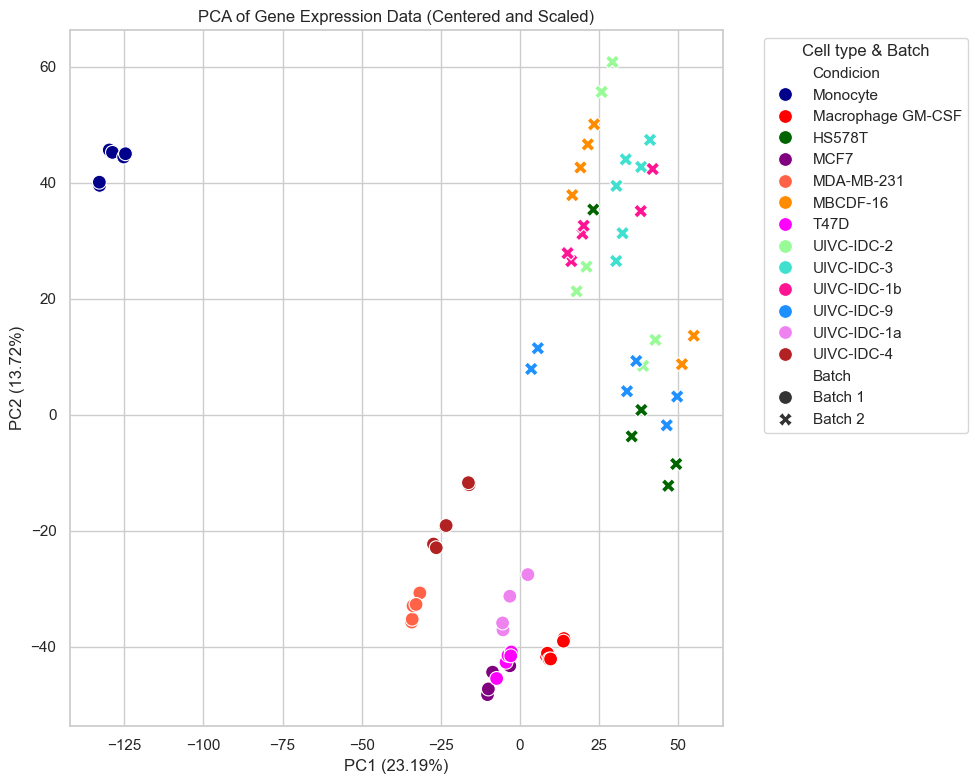

In [10]:
# PCA & Batch  sin centrar ni escalar:
analyze_pca_center_scale_batch("fpkm_all_samples_with_genes_wiso_mean_L1&2.csv")

En este gráfico podemos observar un posible efecto de lote. Para solucionarlo, el primer abordaje consiste en no centrar ni escalar los datos, dado que todos están medidos en la misma unidad de transcripción FPKM y por ende normalizados. El análisis de los datos sin centrar ni escalar viene a continuación.

## **Análisis de Componentes Principales y Efecto de Lote**

Los datos necesarios para construir este análsis son los mismos que usamos anteriormente, solo no se centran ni escalan los datos.

#### **PCA: Lote 1 & 2 con datos sin centrar ni escalar escalar:**

Varianza explicada por cada componente: [5.96278822e+01 1.70466018e+01 9.95654571e+00 3.90037873e+00
 3.22212969e+00 2.23119951e+00 1.20153561e+00 5.73867092e-01
 5.10450395e-01 3.95333053e-01 3.32030227e-01 1.81804098e-01
 1.48616356e-01 1.24375438e-01 9.44563199e-02 6.54589724e-02
 5.23320576e-02 4.42145343e-02 3.11399557e-02 2.63149617e-02
 2.46160943e-02 2.26763358e-02 1.65804569e-02 1.41791733e-02
 1.21295849e-02 1.05302642e-02 9.18713038e-03 7.15626720e-03
 6.52329814e-03 6.38300860e-03 5.87683657e-03 5.22519890e-03
 4.71381471e-03 4.25808013e-03 4.11668535e-03 3.99461269e-03
 3.84191959e-03 3.35433207e-03 3.25697326e-03 3.10450650e-03
 2.97583707e-03 2.84013178e-03 2.75382598e-03 2.66417213e-03
 2.62359432e-03 2.53706848e-03 2.48614847e-03 2.28136189e-03
 2.22652609e-03 2.21180678e-03 2.11816079e-03 2.08177415e-03
 1.99846829e-03 1.94474032e-03 1.87231634e-03 1.81113182e-03
 1.74037325e-03 1.68901859e-03 1.63685220e-03 1.58038029e-03
 1.57348528e-03 1.54551839e-03 1.44637911e-03

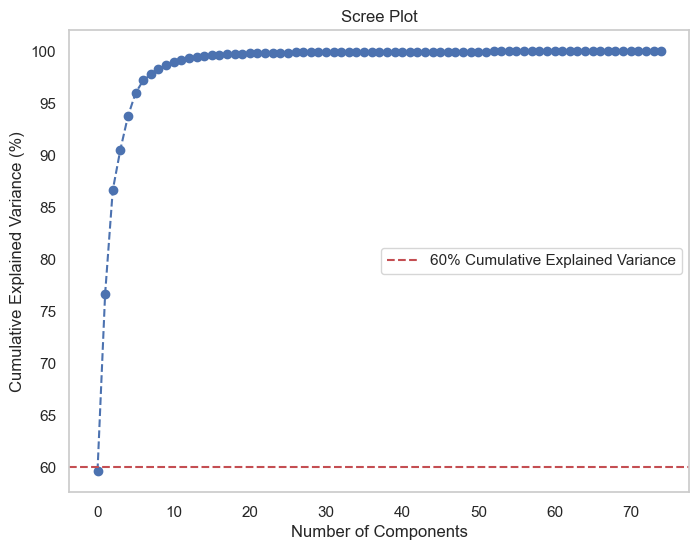

Matriz de Cargas para todas las Componentes Principales:
gene_name     5_8S_rRNA      A1BG      AAAS      AACS     AAGAB      AAK1  \
PC1       -4.220300e-08  0.000004 -0.000029  0.000073  0.000077 -0.000005   
PC2        8.710387e-05  0.000151  0.000058 -0.000232 -0.000308  0.000040   
PC3       -1.472145e-04  0.000111 -0.000150 -0.000260 -0.000254  0.000012   
PC4       -3.074578e-04  0.000175 -0.000280 -0.000469 -0.000017  0.000076   
PC5       -3.033824e-05  0.000352  0.000444  0.000053 -0.000162  0.000225   
...                 ...       ...       ...       ...       ...       ...   
PC71      -6.608705e-04  0.001980  0.008697 -0.000160 -0.002266  0.012807   
PC72       2.421170e-07  0.003597 -0.000425  0.000526 -0.000565  0.011703   
PC73       2.909933e-04  0.005285 -0.006095 -0.001375  0.000288 -0.010261   
PC74       4.408764e-04  0.002661 -0.015426 -0.002635  0.001530  0.019754   
PC75       7.599624e-01 -0.003981  0.159435  0.048867 -0.042283 -0.016866   

gene_name      AAM

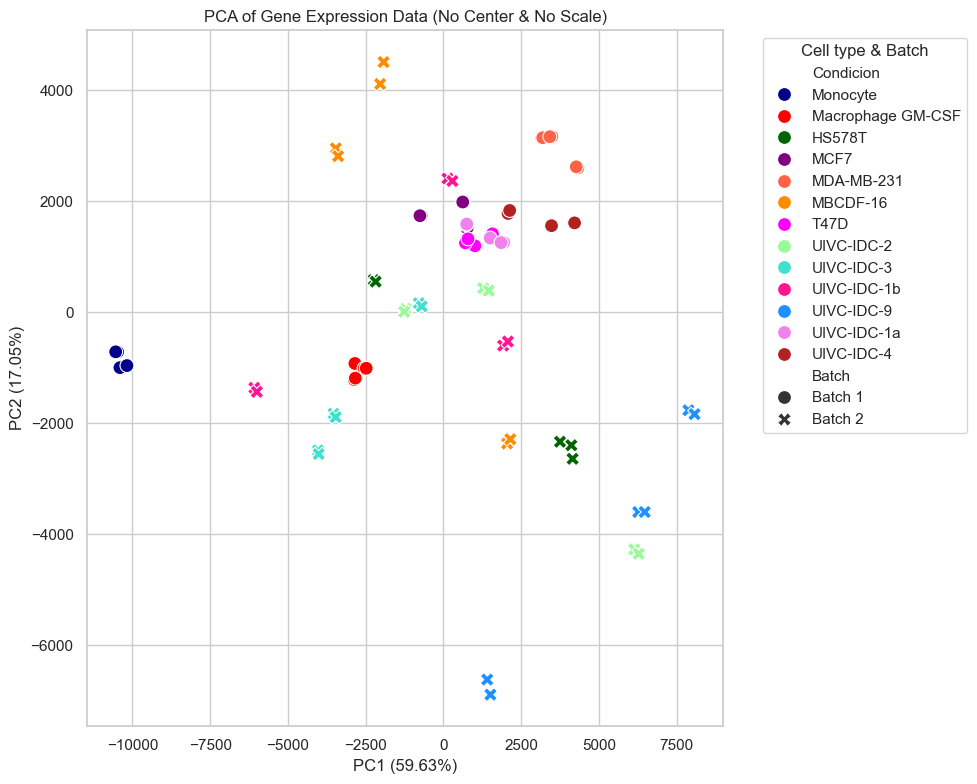

In [ ]:
# PCA & Batch sin centrar ni escalar:
analyze_pca_no_center_scale_batch("fpkm_all_samples_with_genes_wiso_mean_L1&2.csv")

Con este gráfico vemos una mejor armonía entre los macrófagos entrenados por el Microambiente Tumoral (TME) de ambos lotes de secuenciación. Los procentajes explicados por los PC son disitntos a los obtenidos por el análisis en lenguaje R. En esté último la varianza explicada por el PC1 es mayor al 90%, lo cual me intrigaba mucho, me hacía suponer que la variación venía del lote... por ello, quiero saber como descomponer los PC, es decir, que variables los están formando y así descartar que sea un efefcto por lote. Además, podría ver que genes estan siendo los responsables del agrupamineto de las muestras y dirigir el análisis transcripcional hacía ellos. 

### **Búsqueda de clusters:**

In [18]:
# Importar bibliotecas necesarias
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator  # Biblioteca para encontrar el "codo"
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
def analyze_pca_and_cluster(file_path):
    """
    Realiza un análisis de PCA sin centrar ni escalar los datos, realiza clustering con K-means,
    y muestra resultados gráficos incluyendo PCA y clusters.

    Args:
        file_path (str): Ruta al archivo CSV a analizar. Debe tener genes como índices y condiciones experimentales como columnas.
    """
    # Cargar los datos
    data = pd.read_csv(file_path, index_col=0)
    
    # Filtrar y preparar los datos
    data = data.loc[data.sum(axis=1) != 0]  # Eliminar filas cuya suma sea 0
    df_tras = data.T  # Transponer el dataframe
    
    # Realizar PCA
    pca = PCA()
    pca_result = pca.fit_transform(df_tras)
    
    # Crear DataFrame para las dos primeras componentes principales
    pca_data = pd.DataFrame(pca_result[:, :2], columns=['PC1', 'PC2'], index=df_tras.index)
    
    # Calcular varianza explicada
    explained_variance = pca.explained_variance_ratio_ * 100
    cumulative_variance = np.cumsum(explained_variance)
    
    # Mostrar varianza explicada
    print(f"Varianza explicada por cada componente: {explained_variance}")
    print(f"Varianza acumulada: {cumulative_variance}")
    
    # Graficar el Scree Plot
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance (%)')
    plt.title('Scree Plot')
    plt.axhline(60, color='r', linestyle='--', label='60% Cumulative Explained Variance')
    plt.legend()
    plt.grid()
    plt.show()

    # Matriz de cargas
    loadings = pd.DataFrame(
        pca.components_,
        columns=df_tras.columns,
        index=[f'PC{i+1}' for i in range(pca.components_.shape[0])]
    )
    print("Matriz de Cargas para todas las Componentes Principales:")
    print(loadings)
    
    # Asignar etiquetas y lotes (según tu lógica personalizada)
    def assign_label(cond_name):
        if cond_name.startswith("basal_"):
            return "Monocyte"
        elif cond_name.startswith("gmcsf_"):
            return "Macrophage GM-CSF"
        elif cond_name.startswith("uivc_hs"):
            return "HS578T"
        elif cond_name.startswith("mcf7_"):
            return "MCF7"
        elif cond_name.startswith("mda231_"):
            return "MDA-MB-231"
        elif cond_name.startswith("uivc_p16_"):
            return "MBCDF-16"
        elif cond_name.startswith("t47d_"):
            return "T47D"
        elif cond_name.startswith("uivc_160_"):
            return "UIVC-IDC-2"
        elif cond_name.startswith("uivc_169_"):
            return "UIVC-IDC-3"
        elif cond_name.startswith("uivc_172_"):
            return "UIVC-IDC-1b"
        elif cond_name.startswith("uivc_183_"):
            return "UIVC-IDC-9"
        elif cond_name.startswith("uivc1_"):
            return "UIVC-IDC-1a"
        elif cond_name.startswith("uivc4_"):
            return "UIVC-IDC-4"
        else:
            return "Other"

    def assign_batch(cond_name):
        lote1 = ["Monocyte", "Macrophage GM-CSF", "MCF7", "MDA-MB-231", "T47D", "UIVC-IDC-1a", "UIVC-IDC-4"]
        if assign_label(cond_name) in lote1:
            return "Batch 1"
        else:
            return "Batch 2"
    
    pca_data['Condicion'] = pca_data.index.map(assign_label)
    pca_data['Batch'] = pca_data.index.map(assign_batch)
    
    # Paleta personalizada
    custom_palette = {
        "Monocyte": "darkblue",
        "Macrophage GM-CSF": "red",
        "HS578T": "darkgreen",
        "MCF7": "purple",
        "MDA-MB-231": "tomato",
        "MBCDF-16": "darkorange",
        "T47D": "magenta",
        "UIVC-IDC-2": "palegreen",
        "UIVC-IDC-3": "turquoise",
        "UIVC-IDC-1b": "deeppink",
        "UIVC-IDC-9": "dodgerblue",
        "UIVC-IDC-1a": "violet",  
        "UIVC-IDC-4": "firebrick",
        "Other": "black"
    }
    
    # Graficar PCA
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Condicion', style='Batch', palette=custom_palette, s=100)
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title("PCA of Gene Expression Data (No Center & No Scale)")
    plt.legend(title="Cell type & Batch", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # K-means y clustering
    inertia = []
    for n in range(1, 11):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(pca_data[['PC1', 'PC2']])
        inertia.append(kmeans.inertia_)
    
    knee = KneeLocator(range(1, 11), inertia, curve="convex", direction="decreasing")
    n_clusters = knee.knee
    print(f"El número óptimo de clusters es: {n_clusters}")
    
    # Graficar método del codo
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, 11), inertia, marker='o', label='Inercia')
    plt.axvline(n_clusters, color='red', linestyle='--', label=f'Optimal clusters: {n_clusters}')
    plt.title('Elbow Method for K-means')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Clustering final
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    pca_data['Cluster'] = kmeans.fit_predict(pca_data[['PC1', 'PC2']])
    centroids = kmeans.cluster_centers_
    
    print("Tamaño de cada cluster:")
    print(pca_data['Cluster'].value_counts())

    # Agrupar muestras por cluster
    clusters_dict = {cluster: [] for cluster in pca_data['Cluster'].unique()}
    for index, row in pca_data.iterrows():
        clusters_dict[row['Cluster']].append(index)
    
    print("\nMuestras agrupadas por cluster:")
    for cluster, muestras in clusters_dict.items():
        print(f"Cluster {cluster}: {', '.join(muestras)}")
    
    # Graficar PCA con clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_data, x='PC1', y='PC2', hue='Cluster', style='Batch', palette='viridis', s=100)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='*', label='Centroids')
    plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
    plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
    plt.title(f"PCA with K-means Clustering (K={n_clusters}) (No Center & No Scale)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Varianza explicada por cada componente: [5.96278822e+01 1.70466018e+01 9.95654571e+00 3.90037873e+00
 3.22212969e+00 2.23119951e+00 1.20153561e+00 5.73867092e-01
 5.10450395e-01 3.95333053e-01 3.32030227e-01 1.81804098e-01
 1.48616356e-01 1.24375438e-01 9.44563199e-02 6.54589724e-02
 5.23320576e-02 4.42145343e-02 3.11399557e-02 2.63149617e-02
 2.46160943e-02 2.26763358e-02 1.65804569e-02 1.41791733e-02
 1.21295849e-02 1.05302642e-02 9.18713038e-03 7.15626720e-03
 6.52329814e-03 6.38300860e-03 5.87683657e-03 5.22519890e-03
 4.71381471e-03 4.25808013e-03 4.11668535e-03 3.99461269e-03
 3.84191959e-03 3.35433207e-03 3.25697326e-03 3.10450650e-03
 2.97583707e-03 2.84013178e-03 2.75382598e-03 2.66417213e-03
 2.62359432e-03 2.53706848e-03 2.48614847e-03 2.28136189e-03
 2.22652609e-03 2.21180678e-03 2.11816079e-03 2.08177415e-03
 1.99846829e-03 1.94474032e-03 1.87231634e-03 1.81113182e-03
 1.74037325e-03 1.68901859e-03 1.63685220e-03 1.58038029e-03
 1.57348528e-03 1.54551839e-03 1.44637911e-03

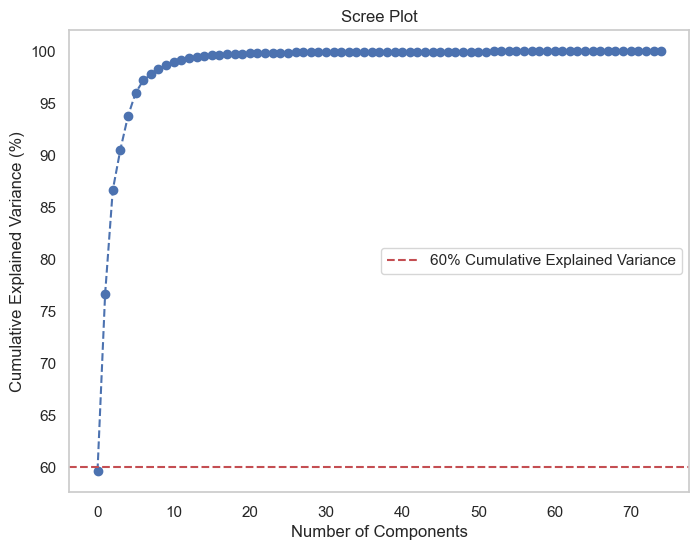

Matriz de Cargas para todas las Componentes Principales:
gene_name     5_8S_rRNA      A1BG      AAAS      AACS     AAGAB      AAK1  \
PC1       -4.220300e-08  0.000004 -0.000029  0.000073  0.000077 -0.000005   
PC2        8.710387e-05  0.000151  0.000058 -0.000232 -0.000308  0.000040   
PC3       -1.472145e-04  0.000111 -0.000150 -0.000260 -0.000254  0.000012   
PC4       -3.074578e-04  0.000175 -0.000280 -0.000469 -0.000017  0.000076   
PC5       -3.033824e-05  0.000352  0.000444  0.000053 -0.000162  0.000225   
...                 ...       ...       ...       ...       ...       ...   
PC71      -6.608705e-04  0.001980  0.008697 -0.000160 -0.002266  0.012807   
PC72       2.421170e-07  0.003597 -0.000425  0.000526 -0.000565  0.011703   
PC73       2.909933e-04  0.005285 -0.006095 -0.001375  0.000288 -0.010261   
PC74       4.408764e-04  0.002661 -0.015426 -0.002635  0.001530  0.019754   
PC75       7.599624e-01 -0.003981  0.159435  0.048867 -0.042283 -0.016866   

gene_name      AAM

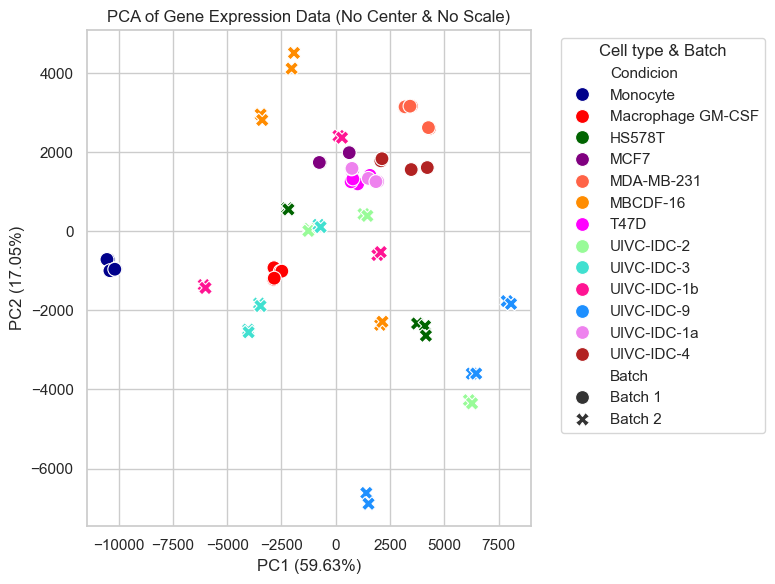

El número óptimo de clusters es: 4


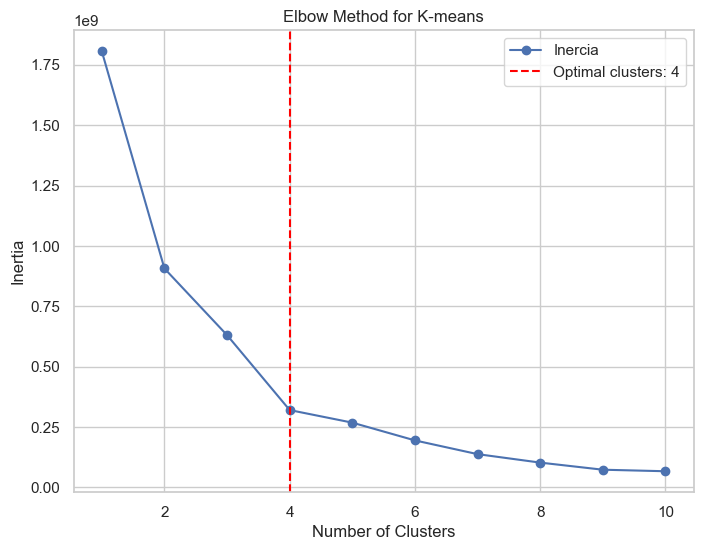

Tamaño de cada cluster:
Cluster
0    35
1    20
3    14
2     6
Name: count, dtype: int64

Muestras agrupadas por cluster:
Cluster 2: basal_1, basal_2, basal_3, basal_4, basal_5, basal_6
Cluster 1: gmcsf_1, gmcsf_2, gmcsf_3, gmcsf_4, gmcsf_5, gmcsf_6, uivc_hs_5, uivc_hs_6, uivc_p16_5, uivc_p16_6, uivc_160_3, uivc_160_4, uivc_169_1, uivc_169_2, uivc_169_3, uivc_169_4, uivc_169_5, uivc_169_6, uivc_172_5, uivc_172_6
Cluster 3: uivc_hs_1, uivc_hs_2, uivc_hs_3, uivc_hs_4, uivc_p16_1, uivc_p16_2, uivc_160_1, uivc_160_2, uivc_183_1, uivc_183_2, uivc_183_3, uivc_183_4, uivc_183_5, uivc_183_6
Cluster 0: mcf7_1, mcf7_2, mcf7_3, mcf7_5, mcf7_6, mda231_1, mda231_2, mda231_3, mda231_4, mda231_5, mda231_6, uivc_p16_3, uivc_p16_4, t47d_1, t47d_3, t47d_4, t47d_5, t47d_6, uivc_160_5, uivc_160_6, uivc_172_1, uivc_172_2, uivc_172_3, uivc_172_4, uivc1_2, uivc1_3, uivc1_4, uivc1_5, uivc1_6, uivc4_1, uivc4_2, uivc4_3, uivc4_4, uivc4_5, uivc4_6


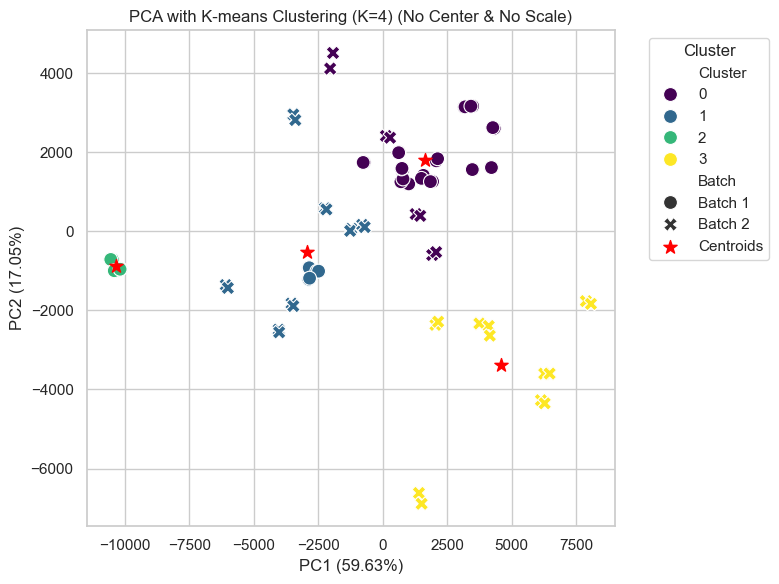

In [26]:
# PCA & Cluster
analyze_pca_and_cluster("fpkm_all_samples_with_genes_wiso_mean_L1&2.csv")